# Analiza zbioru danych związanych z katastrofą Titanica
### Na podsawie poniższej analizy chciałbym zobaczyć i określić czynniki związane z przeżywalonością pasażerów statku, oraz określić który z modeli predykcyjnych poradzi sobie z określeniem który z pasażerów ma największą szansę przeżycia

## 1. Określenie Problemu
### Zrozumienie wpływu czynników decydujących na przezprzywalności pasażerów podczas katastrofy Titanica.
* Czy istnieje różnica w szansach przeżycia między mężczyznami a kobietami?
* Czy klasa biletu związna była z większą szansą przeżycia?
* Czy wiek pasażera miał wpływ na jego szanse przeżycia?
* Czy inne czynniki, takie jak stan cywilny, wielkość rodziny, bądz miejsce na statku miały istone znaczenie.

## 2. Wstępne zapoznanie się z danymi 
### Załadowanie podstawowych bibliotek, oraz bazy danych.

In [268]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)


%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
Titanic = pd.read_csv("Titanic_Database.csv") 
# Baza danych Titanica do sprawdzenie modelu
test = pd.read_csv("test.csv")

In [269]:
Titanic.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [270]:
print(Titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Zbiór danych zawiera następujące informacje:

*  PassengerId: Unikatowy identyfikator pasażera
*  Survived: Czy pasażer przeżył (1) czy zginął (0)
*  Pclass: Klasa biletu (1=pierwsza, 2=druga, 3=trzecia)
*  Name: Imię i nazwisko pasażera, staus cywilny
*  Sex: Płeć pasażera (male, female)
*  Age: Wiek pasażera
*  SibSp: Liczba rodzeństwa i/lub małżonka na pokładzie
*  Parch: Liczba rodziców i/lub dzieci na pokładzie
*  Ticket: Numer biletu
*  Fare: Cena biletu
*  Cabin: Numer kabiny
*  Embarked: Port zaokrętowania (C = Cherbourg, Q = Queenstown, S = Southampton)

## 3. Czyszczenie i przygotowanie danych

In [271]:
#Sprawdzenie wartości zerowych dla głównej bazy danych
print(pd.isnull(Titanic).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [272]:
print(pd.isnull(test).sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### W przypadku głownej bazy danych brakuje 177 kluczowych wartość dla parametru Age, natomiast w przypadku bazy testowej jest to 86 brakująchyc wartości. Kategoria Cabin zostanie w początkowej fazie testó usunięta.


Dodanie kategori Roodzina jako suma paramtrów SibSp, oraz Parch

In [273]:
for df in [Titanic, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch']
Titanic


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


### Encodowanie danych kategorycznych

#### Płeć.

In [274]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

for df in [Titanic, test]:
    sex_encoded = encoder.fit_transform(df['Sex'].values.reshape(-1, 1))  # Dopasuj i przekształc jednocześnie
    df['Sex_Enc'] = sex_encoded

### Male = 1 ||| Female = 0 

#### Stan cywilny paseżerów.

In [275]:
def get_title(name):
    # Wyodrębnij prefix z imienia
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Mlle']:
        return 'Miss'
    elif title in ['Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    else:
        return title

Titanic['Title'] = Titanic['Name'].apply(get_title)
test['Title']    = test['Name'].apply(get_title)
##
#title_percentages1 = Titanic['Title'].value_counts(normalize=True)
#title_percentages2 = test['Title'].value_counts(normalize=True)
#print(title_percentages1)
#print(title_percentages2)

In [276]:
title_mapping = {
    "Mr": 0,
    "Miss": 1,
    "Mrs": 2,
    "Master": 3,
    "Rare": 4,
    "the Countess": 5
}

for df in [Titanic, test]:
    df['Title_Enc'] = np.array([title_mapping[x] for x in df['Title']])

# title_percentages1 = Titanic['Title_Enc'].value_counts(normalize=True)
# title_percentages2 = test['Title_Enc'].value_counts(normalize=True)
# print(title_percentages1)
# print(title_percentages2)

#### Port zaokrętowania

In [277]:
title_mapping = {
    "C": 0,
    "Q": 1,
    "S": 2,
}

for df in [Titanic, test]:
    df['Embarked'] =     pd.Categorical(df['Embarked'])
    df['Embarked_Enc'] = df['Embarked'].cat.codes

# title_percentages1 = Titanic['Embarked_Enc'].value_counts(normalize=True)
# title_percentages2 = test['Embarked_Enc'].value_counts(normalize=True)
# print(title_percentages1)
# print(title_percentages2)

#### Uzupełnianie brakujących wartości
Znacząco wybiegając w przyszłość, ponieważ kolumny Age, Embarked i Fare posiadają brakujące wartości, więc wykorzystując dalej przedstawioną w tekście macierz korelacji perasona zastosuję zależne najmnocniej skolerowane z tymi kolumnami paramtery. 

In [278]:
# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
for df in [Titanic, test]:
    imputer.fit(df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].dropna())
    df['Age'] = imputer.transform(df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

In [279]:
### Dziwny błąd 
mask = Titanic['Embarked_Enc'] == -1
Titanic.loc[mask, 'Embarked_Enc'] = np.nan


# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
for df in [Titanic, test]:
    imputer.fit(df[['Embarked_Enc' ,'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].dropna())
    df['Embarked_Enc'] = imputer.transform(df[['Embarked_Enc', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

In [280]:
# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
imputer.fit(test[['Fare', 'Age', 'Pclass', 'SibSp', 'Parch' ]].dropna())
df['Fare'] = imputer.transform(test[['Fare', 'Age', 'Pclass', 'SibSp', 'Parch' ]])

In [281]:
print(pd.isnull(Titanic).sum())

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
FamilySize        0
Sex_Enc           0
Title             0
Title_Enc         0
Embarked_Enc      0
dtype: int64


In [282]:
print(pd.isnull(test).sum())

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           327
Embarked          0
FamilySize        0
Sex_Enc           0
Title             0
Title_Enc         0
Embarked_Enc      0
dtype: int64


In [283]:
### Sumaryczne wyniki/punkt odniesnia dla danych kattegorycznych, kótóre zostały zencodowane. 

## Wybór danych
#### Ocena kategorii, które mogą zostać bezwzględnie usunięte ponieważ nie planuję uwzględniać ich dalszej części modelowania, bądz zostały zencodowane.   

In [284]:
# Usuń oryginalne kolumny
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
Titanic.drop(columns=categorical_features, inplace=True)
Titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,30.075239,0.523008,0.381594,32.204208,0.904602,0.647587,0.729517,1.533333
std,0.486592,0.836071,13.535628,1.102743,0.806057,49.693429,1.613459,0.477990,1.034144,0.792493
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,2.000000
75%,1.000000,3.000000,38.500000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,5.000000,2.000000


In [285]:
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
test.drop(columns=categorical_features, inplace=True)
test.describe()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.735167,0.447368,0.392344,35.613884,0.839713,0.636364,0.741627,1.401914
std,0.841838,12.932250,0.896760,0.981429,55.841163,1.519072,0.481622,1.006091,0.854496
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,1.000000
50%,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,2.000000
75%,3.000000,36.075000,1.000000,0.000000,31.471875,1.000000,1.000000,1.000000,2.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,10.000000,1.000000,4.000000,2.000000


In [286]:
Titanic[['Age', 'Fare']] = Titanic[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Survived' ,'Pclass', 'SibSp', 'FamilySize',  'Parch', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
Titanic[columns_to_convert] = Titanic[columns_to_convert].astype(np.int16)
Titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int16  
 1   Pclass        891 non-null    int16  
 2   Age           891 non-null    float32
 3   SibSp         891 non-null    int16  
 4   Parch         891 non-null    int16  
 5   Fare          891 non-null    float32
 6   FamilySize    891 non-null    int16  
 7   Sex_Enc       891 non-null    int16  
 8   Title_Enc     891 non-null    int16  
 9   Embarked_Enc  891 non-null    int16  
dtypes: float32(2), int16(8)
memory usage: 21.0 KB


In [287]:
test[['Age', 'Fare']] = test[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Pclass', 'SibSp', 'Parch', 'FamilySize', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
test[columns_to_convert] = test[columns_to_convert].astype(np.int16)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int16  
 1   Age           418 non-null    float32
 2   SibSp         418 non-null    int16  
 3   Parch         418 non-null    int16  
 4   Fare          418 non-null    float32
 5   FamilySize    418 non-null    int16  
 6   Sex_Enc       418 non-null    int16  
 7   Title_Enc     418 non-null    int16  
 8   Embarked_Enc  418 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 9.1 KB


## 4. Wizualizacja i ekspoloracja wzorców

In [288]:
Titanic.groupby('Sex_Enc').mean().round(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title_Enc,Embarked_Enc
Sex_Enc,,,,,,,,,
0,0.74,2.16,28.490000,0.69,0.65,44.48,1.34,1.43,1.41
1,0.19,2.39,30.940001,0.43,0.24,25.52,0.67,0.35,1.60


In [289]:
test.groupby('Sex_Enc').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title_Enc,Embarked_Enc
Sex_Enc,,,,,,,,
0,2.14,29.84,0.57,0.60,49.750000,1.16,1.49,1.32
1,2.33,29.67,0.38,0.27,27.540001,0.65,0.31,1.45


In [290]:
Titanic.groupby('Survived').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
Survived,,,,,,,,,
0,2.53,30.639999,0.55,0.33,22.120001,0.88,0.85,0.40,1.64
1,1.95,29.160000,0.47,0.46,48.400002,0.94,0.32,1.26,1.36


Text(0.5, 1.05, 'Macierz korelacji Perasona')

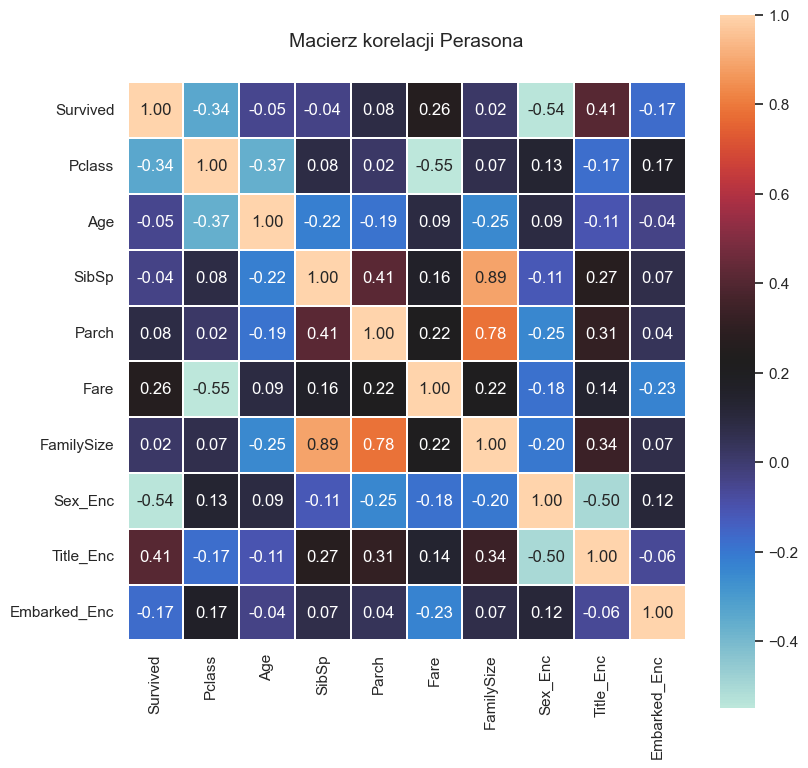

In [291]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

Text(0.5, 1.05, 'Macierz korelacji Perasona')

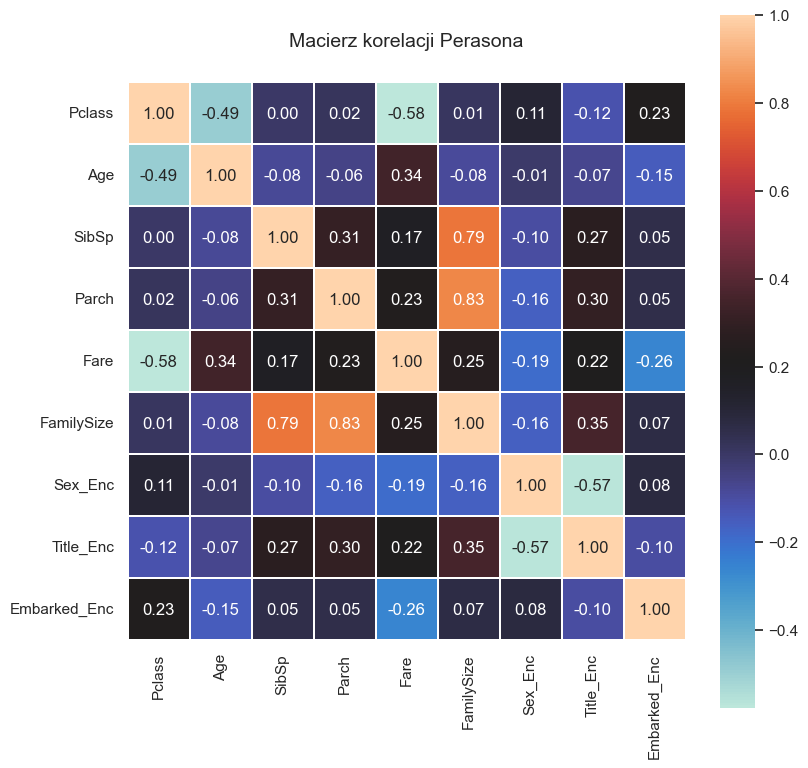

In [292]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(test.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05, size=14)

In [293]:
#sns.pairplot(Titanic, hue="Survived", kind="kde", corner=True)

###  Age distribution

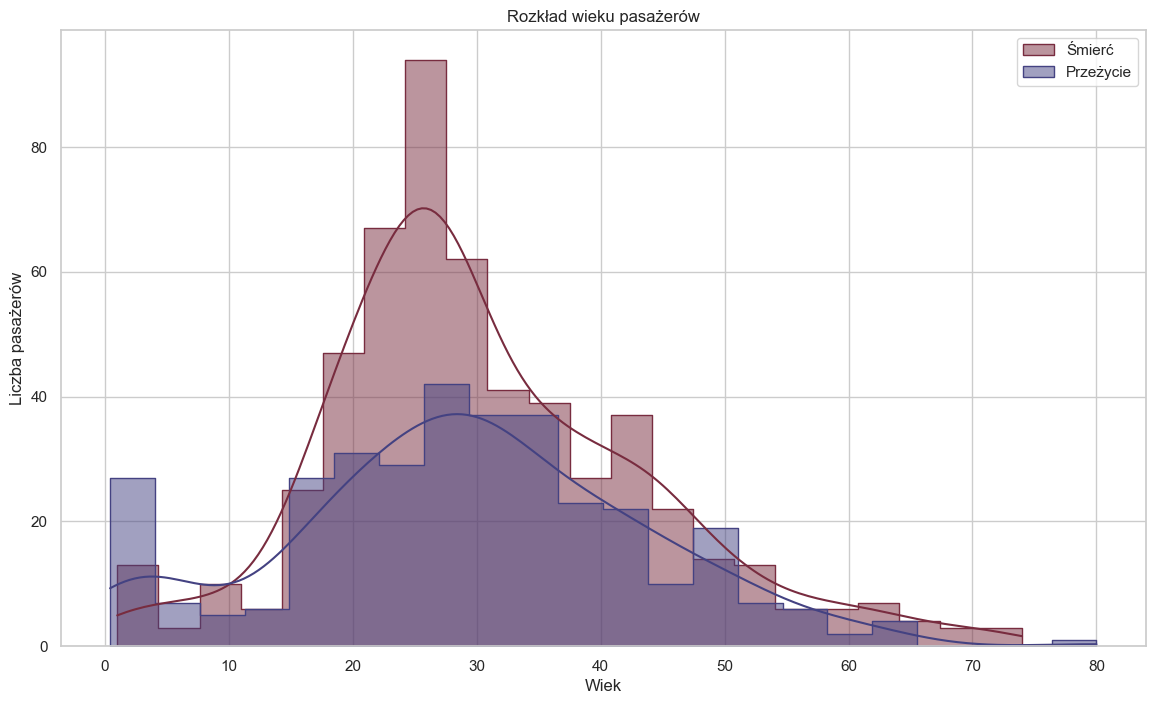

In [294]:
fig, axes = plt.subplots(figsize=(14,8))
axes.set_ylabel('Liczba pasażerów')
axes.set_xlabel('Wiek')
axes.set_title('Rozkład wieku pasażerów')
sns.histplot(Titanic[Titanic['Survived']==0]['Age'],kde=True, bins=22, element='step', label='Śmierć')
sns.histplot(Titanic[Titanic['Survived']==1]['Age'],kde=True, bins=22, element='step', label='Przeżycie')
axes.legend()

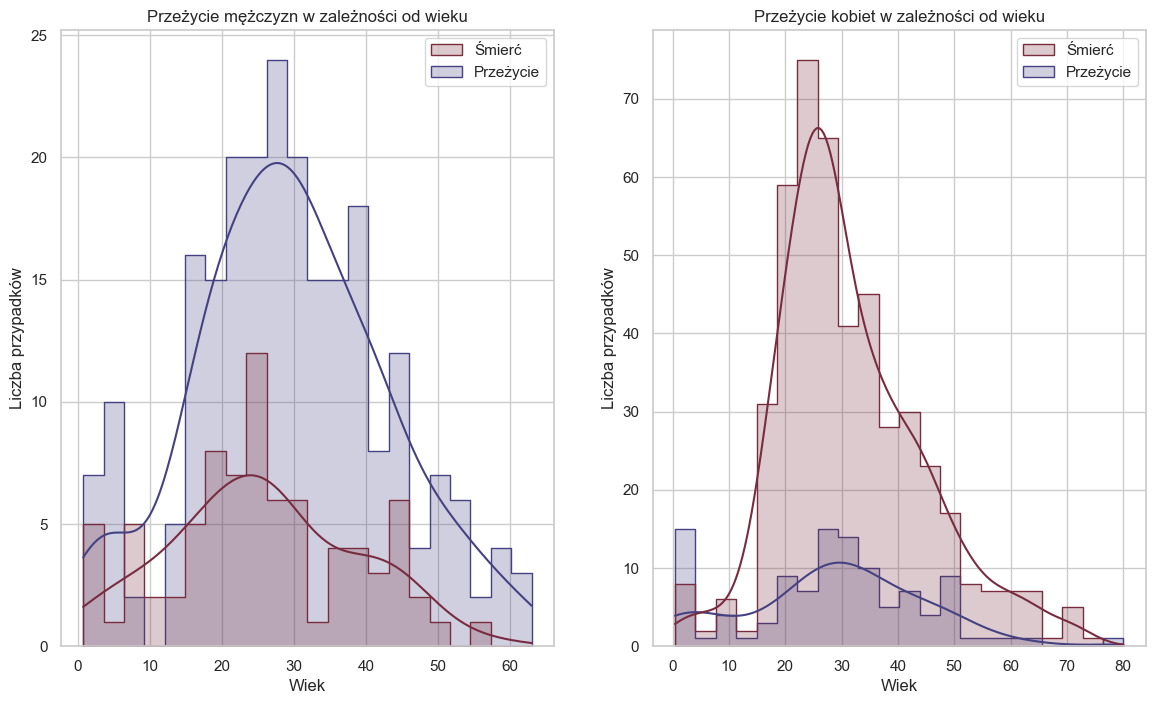

In [295]:
# dwa wykresy
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
# Mężczyźni
sns.histplot(Titanic[Titanic['Sex_Enc']==0], x='Age', hue='Survived', element='step', common_norm=False, ax=ax1, bins=22, kde=True)
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Liczba przypadków')
ax1.set_title('Przeżycie mężczyzn w zależności od wieku')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])
# Kobiety
sns.histplot(Titanic[Titanic['Sex_Enc']==1], x='Age', hue='Survived', element='step', common_norm=False, ax=ax2, bins=22, kde=True)
ax2.set_xlabel('Wiek')
ax2.set_ylabel('Liczba przypadków')
ax2.set_title('Przeżycie kobiet w zależności od wieku')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

C:\Users\domin\AppData\Local\Temp\ipykernel_186272\438540902.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mężczyzni', 'Kobiety'])


Text(0, 0.5, 'Wiek')

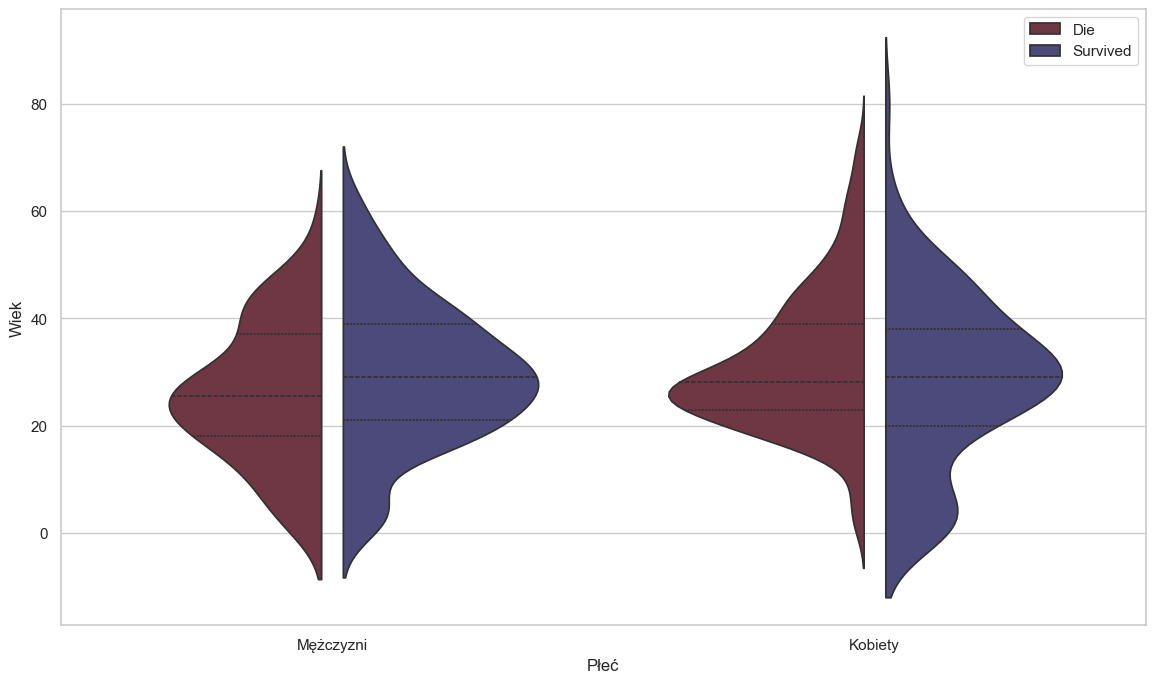

In [296]:
fig, ax = plt.subplots(figsize=(14,8))
sns.violinplot(data=Titanic, x="Sex_Enc", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, ['Die', 'Survived'])
ax.set_xticklabels(['Mężczyzni', 'Kobiety'])
ax.set_xlabel('Płeć')
ax.set_ylabel('Wiek')

Pamiętajmy, że wartość naosi odciętych dla violonplota nie wskazuje częstotoliwości występowania danego zdarzenia. W ziązku z czym kluczowa analiza powinna opierać się głownie na porównaniu krzywej w maksimum. 


### Fare/Calss

<Axes: xlabel='Pclass', ylabel='Fare'>

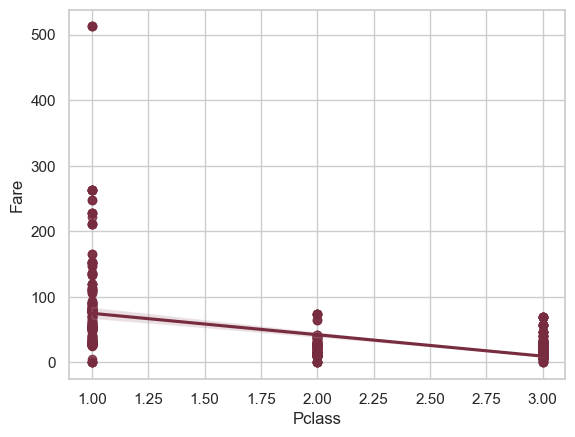

In [297]:
sns.regplot(data=Titanic, x="Pclass", y="Fare")

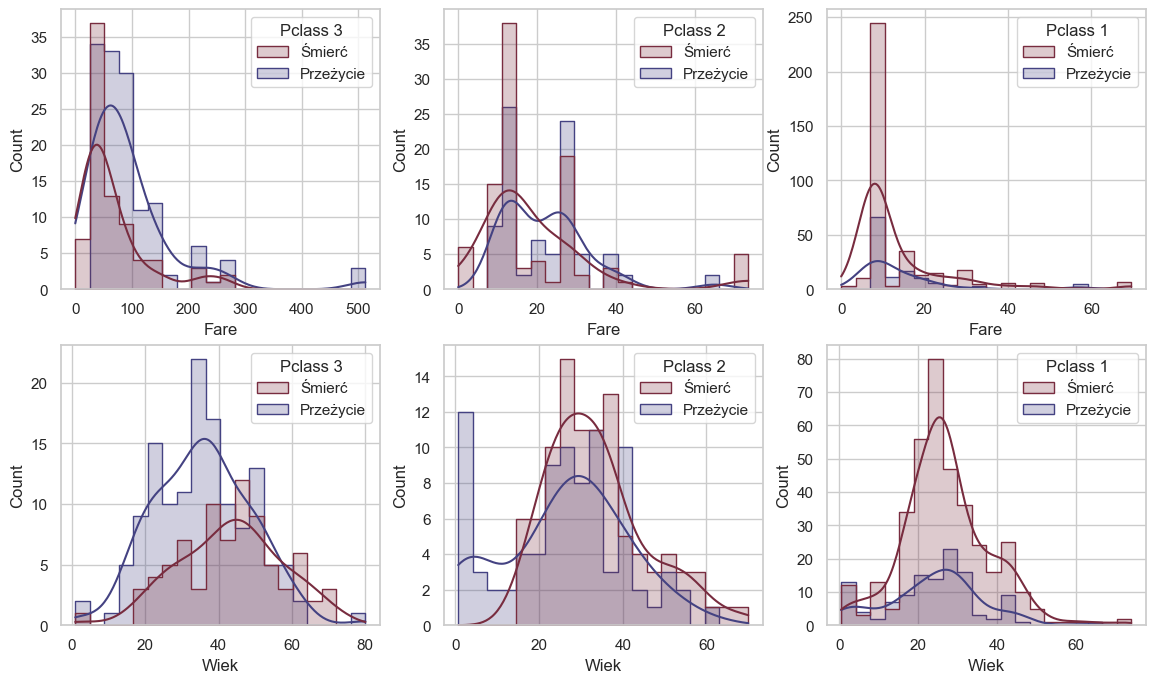

In [298]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.2)
# Create histograms for fares (loop over first row)
for i in range(3):
    sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Fare', hue='Survived', element='step', common_norm=False, ax=axes[0, i], bins=20, kde=True)
    legend = axes[0,i].get_legend()
    handles = legend.legend_handles
    axes[0, i].legend(handles, ['Śmierć', 'Przeżycie'], title = f'Pclass {3-i}')
# Create histograms for age (loop over second row)
for i in range(3):
    sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Age', hue='Survived', element='step', common_norm=False, ax=axes[1, i], bins=20, kde=True)
    axes[1, i].set_xlabel('Wiek')
    legend = axes[1,i].get_legend()
    handles = legend.legend_handles
    axes[1, i].legend(handles, ['Śmierć', 'Przeżycie'], title = f'Pclass {3-i}')

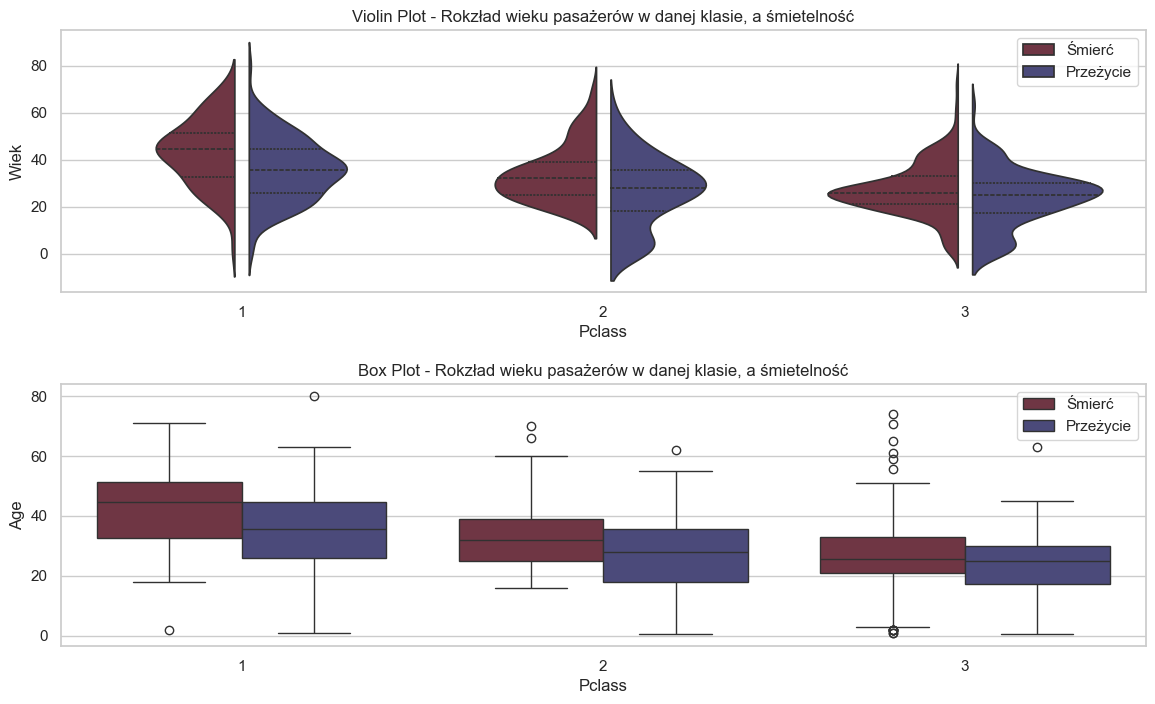

In [299]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.35)
sns.violinplot(ax=ax1, data=Titanic, x="Pclass", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
ax1.set_title('Violin Plot - Rokzład wieku pasażerów w danej klasie, a śmietelność')
ax1.set_ylabel('Wiek')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])

# Box plot on the second subplot (axes[1])
sns.boxplot(ax=ax2, data=Titanic, x="Pclass", y="Age", hue="Survived")
ax2.set_title('Box Plot - Rokzład wieku pasażerów w danej klasie, a śmietelność')
ax1.set_ylabel('Wiek')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])


### Rodzina

C:\Users\domin\AppData\Local\Temp\ipykernel_186272\1834844578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Titanic,   x='FamilySize', y='Survived', palette="icefire", ax=ax1)
C:\Users\domin\AppData\Local\Temp\ipykernel_186272\1834844578.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])


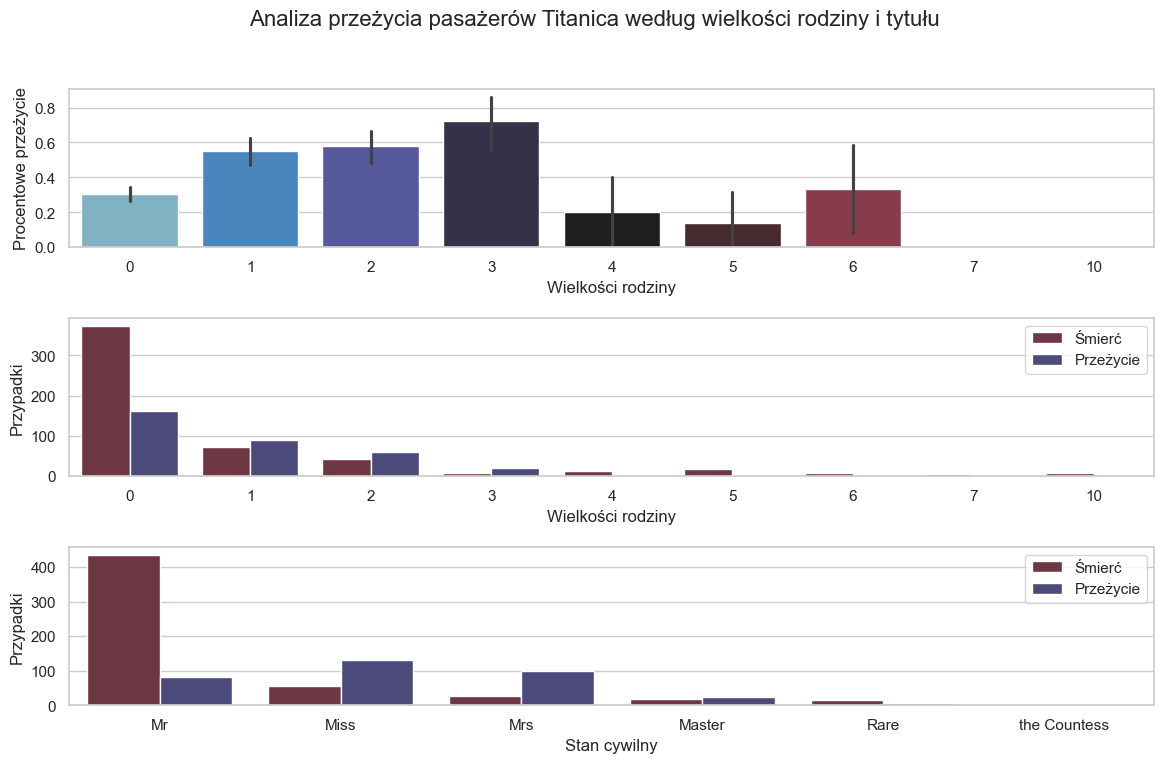

In [300]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 8))
plt.subplots_adjust(hspace=0.45)
fig.suptitle('Analiza przeżycia pasażerów Titanica według wielkości rodziny i tytułu', fontsize=16)
ax1.set_xlabel('Wielkości rodziny')
ax1.set_ylabel('Procentowe przeżycie')
sns.barplot(data=Titanic,   x='FamilySize', y='Survived', palette="icefire", ax=ax1)

sns.countplot(data=Titanic, x='FamilySize', hue='Survived',  ax=ax2)
ax2.set_ylabel('Przypadki')
ax2.set_xlabel('Wielkości rodziny')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

title_mapping = {
    "Mr": 0,
    "Miss": 1,
    "Mrs": 2,
    "Master": 3,
    "Rare": 4,
    "the Countess": 5
}

sns.countplot(data=Titanic, x='Title_Enc', hue='Survived',  ax=ax3)
ax3.set_ylabel('Przypadki')
ax3.set_xlabel('Stan cywilny')
ax3.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])
legend = ax3.get_legend()
handles = legend.legend_handles
ax3.legend(handles, ['Śmierć', 'Przeżycie'])


### Zaokrętowanie  

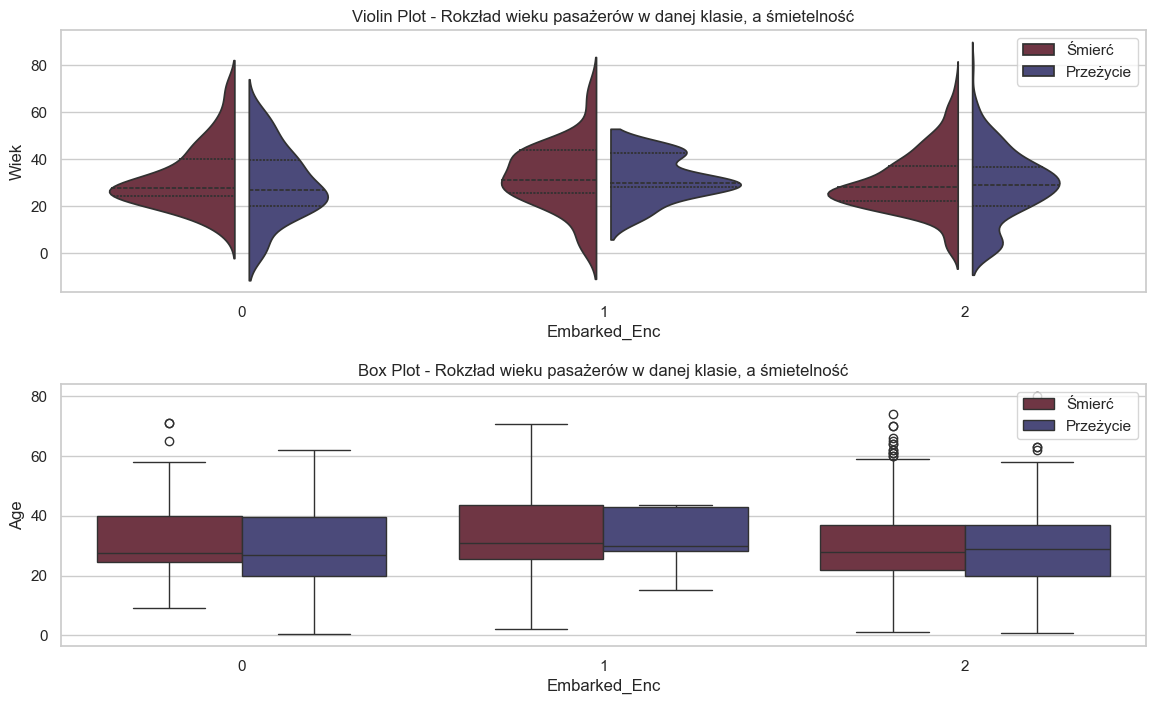

In [301]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.35)
sns.violinplot(ax=ax1, data=Titanic, x="Embarked_Enc", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
ax1.set_title('Violin Plot - Rokzład wieku pasażerów w danej klasie, a śmietelność')
ax1.set_ylabel('Wiek')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])

# Box plot on the second subplot (axes[1])
sns.boxplot(ax=ax2, data=Titanic, x="Embarked_Enc", y="Age", hue="Survived")
ax2.set_title('Box Plot - Rokzład wieku pasażerów w danej klasie, a śmietelność')
ax1.set_ylabel('Wiek')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

## Modele

In [302]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.naive_bayes     import GaussianNB

from sklearn.svm             import SVC

from sklearn.neighbors       import KNeighborsClassifier




In [303]:
#Baza danych do nauki
X = Titanic.drop('Survived',axis=1)
y = Titanic['Survived']
y_test = test

In [304]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier()],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Support Vector Machine', SVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Naive Bayes',GaussianNB()]
              ]
               


In [305]:
## Wstępna ocena wydajności modeli z domyślnymi parametrami
for metric in ['accuracy','f1']:
    SKfold = StratifiedKFold(n_splits=6)
    score_mean = []
    std = []
    
    for model in classifiers:
        clf = model[1]
        cv_result = cross_val_score(clf,X,y, cv = SKfold, scoring = metric)
        cv_result = cv_result
        score_mean.append(cv_result.mean())
        std.append(cv_result.std())
        
    models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
    print(models_evaluation.sort_values(metric, ascending=False))
    print('*'*32)

                        accuracy
Gradient Boosting       0.827159
HGBC                    0.821543
AdaBoost                0.812572
Random Forest           0.804742
Naive Bayes             0.790155
Support Vector Machine  0.683559
********************************
                              f1
Gradient Boosting       0.759721
HGBC                    0.754738
AdaBoost                0.753378
Random Forest           0.742790
Naive Bayes             0.734422
Support Vector Machine  0.421462
********************************


### Fine tuning

In [306]:
# from sklearn.metrics import accuracy_score, f1_score, make_scorer
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# # Define parameter grids for each classifier
# param_grids = {
#     'Random Forest': {
#         'n_estimators': [150, 175, 200, 225, 250, 300],
#         'max_depth': [3, 4, 5, 6, 7]
#     },
#     'AdaBoost': {
#         'n_estimators': [150, 175, 200, 225, 250],
#         'learning_rate': [0.75, 0.85, 0.95, 1.0]
#     },
#     'Gradient Boosting': {
#         'n_estimators': [75, 100, 125, 150, 200],
#         'learning_rate': [0.1, 0.2, 0.25, 0.3, 0.35]
#     },
#     'Support Vector Machine': {
#         'C': [0.025, 0.05, 0.75, 0.1, 0.15, 0.25],
#         'kernel': ['linear', 'rbf']
#     },
#     'MLPC': {
#         'max_iter': [8000],
#         'solver' : ['adam'],
#         'learning_rate_init' : [0.0175, 0.02, 0.0225, 0.025, 0.03],
#         'alpha':                [0.0001, 0.00015, 0.0002, 0.00025],
#         'hidden_layer_sizes':  [(12,12), (8,8), (6,6), (3,3,3), (7,7,7) ],
#         'activation': ['relu', 'tanh']
        
#     },
#     'HGBC': {
#         'learning_rate': [0.05, 0.1, 0.25, 0.5, 1.0]
#     }
# }

# classifiers = [
#     ('Random Forest', RandomForestClassifier()),
#     ('AdaBoost', AdaBoostClassifier()),
#     ('Gradient Boosting', GradientBoostingClassifier()),
#     ('Support Vector Machine', SVC()),
#     ('MLPC', MLPClassifier()),
#     ('HGBC', HistGradientBoostingClassifier())
    
# ]



# # Perform GridSearchCV for each classifier with accuracy evaluation
# for name, clf in classifiers:
#     # Create a scoring function (using accuracy_score)
#     param_grid = param_grids[name]
#     # 1. Refit with a specific metric (e.g., 'accuracy')
#     scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
#     grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=SKfold, scoring=scoring, refit='accuracy')

#     # 2. No refitting (evaluate across all metrics)
#     # scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
#     # grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, scoring=scoring, refit=False)
#     #grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=scoring)  # Adjust cv as needed
    
#     grid_search.fit(X, y)

#     # Print the best model's accuracy and parameters
#     best_model = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     best_params = grid_search.best_params_

#     print(f"\n{name} Model:")
#     print(f"Best Accuracy on Training Data: {best_score:.4f}")
#     print(f"Best Parameters: {best_params}")

#     # Evaluate the best model on the test set
#     #y_pred = best_model.predict(X_test)
#     # test_accuracy = accuracy_score(y_test, y_pred)
#     #print(f"Accuracy on Test Data: {test_accuracy:.4f}")

In [307]:
# from sklearn.preprocessing import PolynomialFeatures
# # Wybierz parametry
# features = ['Sex_Enc', 'FamilySize']

# # Utwórz obiekt PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=True)

# # Przekształć dane
# X_fare_sex = poly.fit_transform(Titanic[features])

# # Dodaj kolumny z nowymi cechami do DataFrame
# Titanic['Fare_Sex_Poly2'] = X_fare_sex[:, 1]
# Titanic['Fare_Sex_Poly3'] = X_fare_sex[:, 2]

# # Wyświetl pierwsze 5 wierszy DataFrame
# fig, ax = plt.subplots(figsize=(9, 9))
# sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
# ax.set_title('Pearson Correlation of Features', y=1.05, size=15)
# Titanic.head(20)

## Weryfikacja modeli

In [308]:
Titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
0,0,3,22.000000,1,0,7.250000,1,1,0,2
1,1,1,38.000000,1,0,71.283302,1,0,2,0
2,1,3,26.000000,0,0,7.925000,0,0,1,2
3,1,1,35.000000,1,0,53.099998,1,0,2,2
4,0,3,35.000000,0,0,8.050000,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.000000,0,1,4,2
887,1,1,19.000000,0,0,30.000000,0,0,1,2
888,0,3,26.799999,1,2,23.450001,3,0,1,2
889,1,1,26.000000,0,0,30.000000,0,1,0,0


In [309]:
test

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
0,3,34.5,0,0,7.829200,0,1,0,1
1,3,47.0,1,0,7.000000,1,0,2,2
2,2,62.0,0,0,9.687500,0,1,0,1
3,3,27.0,0,0,8.662500,0,1,0,2
4,3,22.0,1,1,12.287500,2,0,2,2
...,...,...,...,...,...,...,...,...,...
413,3,23.6,0,0,8.050000,0,1,0,2
414,1,39.0,0,0,108.900002,0,0,4,0
415,3,38.5,0,0,7.250000,0,1,0,2
416,3,23.6,0,0,8.050000,0,1,0,2


   # Evaluate accuracy on the test set
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Print results for each model
    print(f"Model: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print('-' * 32)

## Kod zapasowy w markdown więc nie będzie się wyświetlać poprawnie

---------------------------